<a href="https://colab.research.google.com/github/helonayala/pinn/blob/main/01_DeepVIV_sec21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Physics-informed Artificial Neural Network for Friction Identification

Author: Helon Ayala, October 2020

# Quick description



# Problem definition

In summary, we will use the Physics-informed artificial neural networks (PINNs) for solving the forward and inverse problems related to the dynamics of a positioning system with friction

$$
\rho \ddot x (t) + b \dot x (t) + k x (t) = f (t)
$$

where the terms are described as follows
* $\rho, b, k$: inertia, viscous friction, and rigidity, respectively;
* $x(t)$: displacement;
* $f(t)$: sum of external forces

On one hand, the forward problem relates to solving numerically the 2nd order ODE described in the EOM given. On the other hand, the inverse problems related to inferring the parameters of the system: $\rho, b,k$

# Assumptions

We work under the assumptions that
* we know the time series $[x(t),f(t)]$, and
* we know the constitutive model of the system under study

# Imports and definitions 


In [3]:
#@title
!pip install -U tensorflow-addons
!pip install -q "tqdm>=4.36.1"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# progress bar for model.fit function
import tensorflow_addons as tfa
import tqdm

# set random seed for reproduction
tf.random.set_seed(42)

# initialize tqdm callback
tqdm_callback = tfa.callbacks.TQDMProgressBar(
  leave_epoch_progress = True,
  leave_overall_progress = True,
  show_epoch_progress = False,
  show_overall_progress = True,
  )


Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: tensorflow-addons in /home/helon/.local/lib/python3.8/site-packages (0.11.2)


# Load data and plot

There are 24841 samples


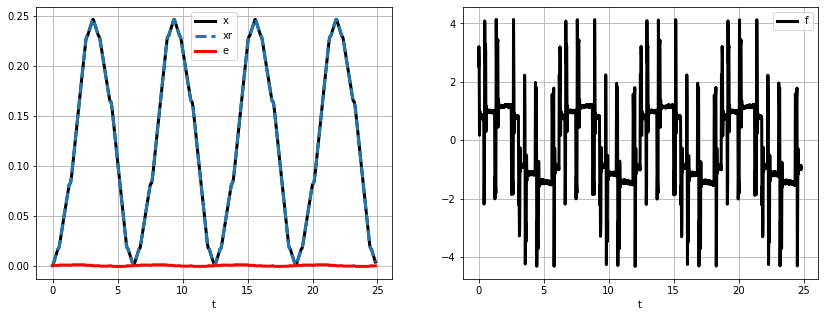

In [8]:

EMPS = loadmat(os.path.join("data", "DATA_EMPS.mat"))

xr = EMPS['qg'].astype(np.float32) # reference for x, identification is in closed-loop
x  = EMPS['qm'].astype(np.float32)
f  = EMPS['vir'].astype(np.float32)
t  = EMPS['t'].astype(np.float32)
ts = np.mean(np.diff(t.ravel())) 

N_train = t.shape[0] # how much data ?

print('There are %d samples' % N_train)

# time series plots 
plt.figure(figsize=[14,5])
plt.subplot(121)
plt.plot(t,x,'k',t,xr,'--',t,xr-x,'r-',linewidth=3)
plt.legend(['x','xr','e'])
plt.xlabel('t')
plt.grid()

plt.subplot(122)
plt.plot(t,f,'k',linewidth=3)
plt.legend('f')
plt.xlabel('t')
plt.grid()
plt.show()

# Layer class

Here we define the layers for the PINNs usign tf.keras and subclassing.

Although semantically I think it would be clearer to use 2 layers objects (1 for the $\hat x = f(t) $ and 1 for the ODE/inverse problem), I had to use one layer for both PINN blocks. I could not make it work with 2 different layers, probably because of the inner functioning of the tf.GradientTape function (to be investigated ...).

In [9]:

# Implements the first block: mapping time (the independent variable) to x (the state)
class tToXandF(tf.keras.layers.Layer):
    def __init__(self, layerWidth, actFcn, name="tToX", **kwargs):
        super(tToXandF, self).__init__(name=name, **kwargs)

        self.layerWidth = layerWidth
        self.actFcn = actFcn

        # instantiates all layers recursively
        self.denseList = []
        for nNeurons in self.layerWidth:
            self.denseList.append(
                tf.keras.layers.Dense(nNeurons, activation=self.actFcn)
            )  # hidden layers

        self.denseList.append(tf.keras.layers.Dense(1))  # output layer

        self.b = tf.Variable(0.05, name="b", trainable=True, dtype=tf.float32)
        self.k = tf.Variable(2.0, name="k", trainable=True, dtype=tf.float32)

    def call(self, t):

        with tf.GradientTape(
            persistent=True  # persistent for 2nd order derivative
        ) as tape:

            tape.watch(t)
            # part 1: calculate  t->x
            for nLayers in range(self.denseList.__len__()):
                if nLayers == 0:
                    x = self.denseList[nLayers](t)
                else:
                    x = self.denseList[nLayers](x)

            # part 2a: calculate the gradients of x wrt t
            xp = tape.gradient(x, t)
            xpp = tape.gradient(xp, t)

            # part 2b: calculate the EOM
            f = 2.0 * xpp + self.b * xp + self.k * x

        return x, f

# Model class

The model class in tf.keras makes it very easy to train models and predict. 

It combines the 2 blocks for PINN end-to-end training.

In [10]:
class PINN(tf.keras.Model):
    def __init__(self, layerWidth=10 * [32], actFcn=tf.sin, name="PINN", **kwargs):
        super(PINN, self).__init__(name=name, **kwargs)

        self.tToXandF = tToXandF(layerWidth=layerWidth, actFcn=actFcn)

    def call(self, t):
        return self.tToXandF(t)


# Train the model

In [13]:
mdl = PINN()  # default parameters are the same as DeepVIV paper
# mdl = PINN(layerWidth=4 * [16], actFcn="sigmoid")

lrvec = np.array([1e-3, 1e-4, 1e-5, 1e-6])
epvec = np.array([2e3, 3e3, 3e3, 2e3], dtype="int32")

nTrain = lrvec.shape[0]
for i in range(nTrain):
    print("Learning rate:", lrvec[i])
    mdl.compile(
        tf.keras.optimizers.Adam(learning_rate=lrvec[i]), loss="mse", metrics="mse"
    )
    mdl.fit(
        x=t,
        y=[x, f],
        epochs=epvec[i],
        batch_size=N_train,
        verbose=1,
        # callbacks=[tqdm_callback],
    )

output_2_loss: 0.3765 - output_1_mse: 0.0644 - output_2_mse: 0.3765
Epoch 1889/2000
1/1 [==============================] - 0s 755us/step - loss: 0.4408 - output_1_loss: 0.0644 - output_2_loss: 0.3765 - output_1_mse: 0.0644 - output_2_mse: 0.3765
Epoch 1890/2000
1/1 [==============================] - 0s 694us/step - loss: 0.4408 - output_1_loss: 0.0644 - output_2_loss: 0.3764 - output_1_mse: 0.0644 - output_2_mse: 0.3764
Epoch 1891/2000
1/1 [==============================] - 0s 899us/step - loss: 0.4408 - output_1_loss: 0.0644 - output_2_loss: 0.3764 - output_1_mse: 0.0644 - output_2_mse: 0.3764
Epoch 1892/2000
1/1 [==============================] - 0s 696us/step - loss: 0.4408 - output_1_loss: 0.0644 - output_2_loss: 0.3764 - output_1_mse: 0.0644 - output_2_mse: 0.3764
Epoch 1893/2000
1/1 [==============================] - 0s 697us/step - loss: 0.4408 - output_1_loss: 0.0644 - output_2_loss: 0.3764 - output_1_mse: 0.0644 - output_2_mse: 0.3764
Epoch 1894/2000
1/1 [=====================

# Outputs and checks

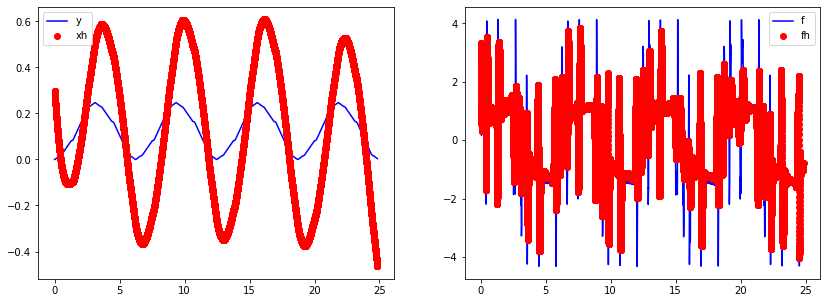

Values identified for the ODE (rho = 2.0, b = 0.084, k = 2.2020 are the real values)
<tf.Variable 'b:0' shape=() dtype=float32, numpy=1.8865381>
<tf.Variable 'k:0' shape=() dtype=float32, numpy=-0.018937593>


In [14]:

xh, fh = mdl.predict(t)

plt.figure(figsize=[14, 5])
plt.subplot(121)
plt.plot(t, x, "b-", t, xh, "ro")
plt.legend(["y", "xh"])

plt.subplot(122)
plt.plot(t, f, "b-", t, fh, "ro")
plt.legend(["f", "fh"])
plt.show()

print(
    "Values identified for the ODE (rho = 2.0, b = 0.084, k = 2.2020 are the real values)"
)
print(mdl.weights[0])
print(mdl.weights[1])


In [7]:
mdl.summary()

Model: "PINN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tToX (tToXandF)              multiple                  9603      
Total params: 9,603
Trainable params: 9,603
Non-trainable params: 0
_________________________________________________________________
